In [51]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd
import numpy as np

In [52]:
file_path = 'diabetes.csv'
df = pd.read_csv(file_path)

display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [53]:
# Remove NaN rows in data

df_no_nan = df.dropna()
df_no_nan.to_csv('diabetes_removed_nan.csv', index=False)

new_df = pd.read_csv("diabetes_removed_nan.csv")

display(new_df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [54]:
# Standardize data

features = [col for col in df.columns if col not in ['Outcome', 'DiabetesPedigreeFunction']]
x = new_df.loc[:, features].values
x = StandardScaler().fit_transform(x)

In [55]:
# PCA

pca = PCA()
principalComponents = pca.fit_transform(x)

In [56]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7'])

In [57]:
print(pca.explained_variance_ratio_)

[0.28728614 0.24504176 0.1424166  0.10920261 0.09775728 0.06051123
 0.05778439]


/var/folders/tc/p_2dw00d5zg0svx3_qj__8tc0000gn/T/ipykernel_38293/1801381452.py:5: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],


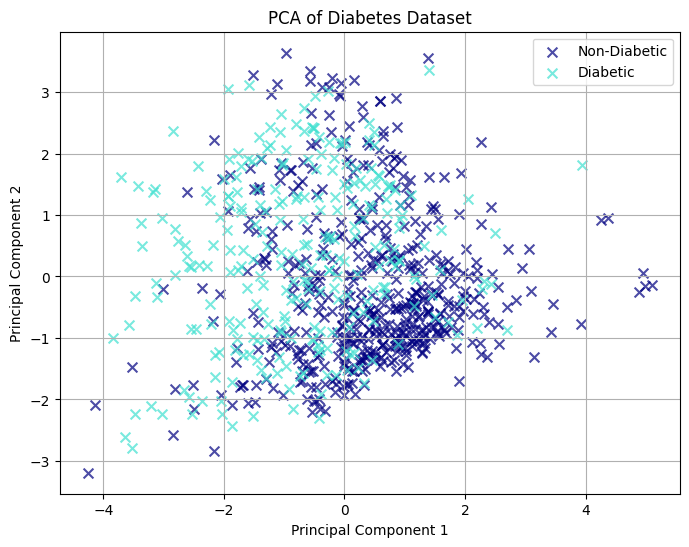

In [58]:
plt.figure(figsize=(8, 6))

for outcome, color in zip([0, 1], ["#000080", "#40E0D0"]):
    indicesToKeep = new_df['Outcome'] == outcome
    plt.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
                principalDf.loc[indicesToKeep, 'principal component 2'],
                c=color, edgecolor='k', alpha=0.7, s=50, marker='x',
                label=('Non-Diabetic' if outcome == 0 else 'Diabetic'))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Diabetes Dataset')
plt.grid(True)
plt.legend()
plt.show()


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (8,) and arg 1 with shape (7,).

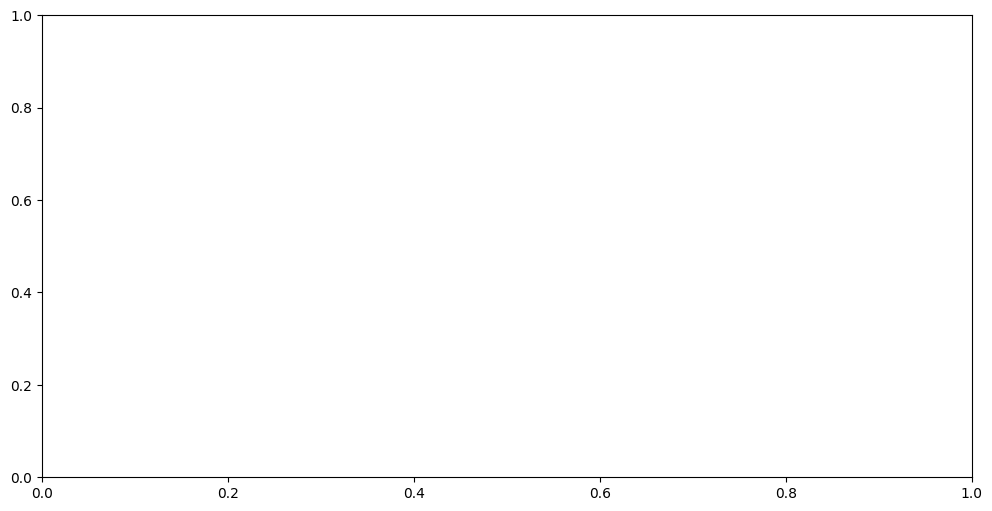

In [59]:
Y = x - np.ones((x.shape[0], 1)) * x.mean(0)
U, S, Vh = svd(Y, full_matrices=False)
V = Vh.T

new_new_df = new_df.drop('Outcome', axis=1)
attributeNames = list(new_new_df.columns)

pcs = [0, 1, 2]
legendStrs = ["PC" + str(e + 1) for e in pcs]
bw = 0.2
r = np.arange(1, len(attributeNames) + 1)
colors = ["r", "g", "b"]  

plt.figure(figsize=(12, 6))
for i in pcs:
    plt.bar(r + i * bw, V[:, i], width=bw, color=colors[i])
plt.xticks(r + bw, attributeNames, rotation=45, ha="right")
plt.xlabel("Attributes")
plt.ylabel("Component coefficients")
plt.legend(legendStrs)
plt.grid()
plt.title("Diabetes Dataset: PCA Component Coefficients")
plt.tight_layout()  
plt.show()


ValueError: 'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 768.

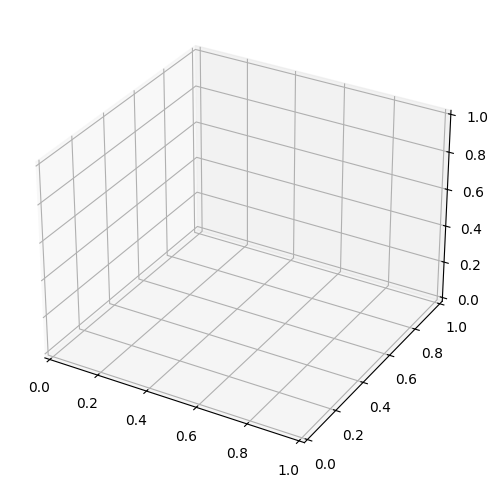

In [ ]:
# Plotting 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extracting the values for each component
x_values = principalDf['principal component 1']
y_values = principalDf['principal component 2']
z_values = principalDf['principal component 3']

# Plotting
ax.scatter(x_values, y_values, z_values, c= colors, marker='o')

# Adding labels for each axis
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Title
ax.set_title('3D PCA Plot')

# Show plot
plt.show()